![alt text](airbnb-logo.png "Title")
# Airbnb Data Project Round 2
So upon reflection, I have decided to forsake Kaggle and to search for data sources on the internet, so that I go through the process of looking for data. After a few days of searching, I chanced upon this website [Inside Airbnb](http://insideairbnb.com/get-the-data.html) that had a trove of airbnb data from an anti-Airbnb advocate. I have downloaded the Nov 2015 SF data and it looks promising so far--let's see what we can do with it.

In [6]:
import pandas as pd
pd.set_option('precision', 2)

# Data sourced from Inside Airbnb (http://insideairbnb.com/get-the-data.html)
# A million thanks to Murray Cox
calendar = pd.read_csv("calendar.csv")
calendar2 = pd.read_csv("calendar2.csv")
listings = pd.read_csv("listings.csv")
listings2 = pd.read_csv("listings2.csv")
nhoods = pd.read_csv("neighbourhoods.csv")
reviews = pd.read_csv("reviews.csv")
reviews2 = pd.read_csv("reviews2.csv")

For a start, we will be looking at the listings2 datsset. From the list of data fields, we can see that this dataset is reasonably extensive, **with listing details, and reviews related data**. There are also a number of text fields describing the listing that may prove to be useful for our Naive Bayes purposes.

As Airbnb compels each user to write a review after each stay, the **number of reviews is a good proxy of the popularity of the listing**. Should Airbnb be able to predict a popular location in advance, it can give the location more airtime/exposure, and improve the overall experience to users, as users are able to find something they like more quickly. 

In [7]:
list(listings2)

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',
 'square_feet',
 'price',
 'weekly_price',


If we look at the end of the list, we see an interesting feature. Reviews per month would weigh the number of reviews against the duration which the location has been listed on Airbnb, giving a more normalized sensing of popularity. 

As starters, **I will use reviews per month as the response variable (y), and summary as the feature (X)**. As the summary field contains text, I can use what we have been learning in class to see if it is predictive. 

In [8]:
listings2[['summary', 'reviews_per_month']].head()

,summary,reviews_per_month
0,This is a big well designed space. Our neighbo...,0.28
1,Beautiful charmng multi- bedroom home in prest...,NaN
2,Convenience is the key for your travel. Walkin...,2.33
3,"When I travel, my quiet beach side condo makes...",NaN
4,Our family-friendly condo is located in San Fr...,0.36


As we can observe that there are some NAs, we will drop NAs from the field and **name the subset summary_to_reviews**.

In [9]:
summary_to_reviews = listings2[['summary', 'reviews_per_month']].dropna()
summary_to_reviews.head()

,summary,reviews_per_month
0,This is a big well designed space. Our neighbo...,0.28
2,Convenience is the key for your travel. Walkin...,2.33
4,Our family-friendly condo is located in San Fr...,0.36
5,Large 2BD apt with back yard and ocean view. F...,1.13
6,Newly built cottage that comfortably sleeps 2....,6.09


At this juncture, I'm wondering if NA means zero/blank, or NA means missing data?. Either way, that's an aspect of the data I might want to keep in mind for later rounds. In the meantime, the subset data, with 5000+ rows, should do as a first attempt.

With summary_to_reviews, we will now attempt to answer the question **"Are we able to predict the popularity of a listing just from its summary description?"**. This can be a valuable question to solve from a marketing or copywriting standpoint.

As for reviews_per_month, we can try to understand the metric better by looking at the summary statistics. Specifically, we are looking at how to define popularity.

In [10]:
summary_to_reviews.reviews_per_month.describe()

count    5157.00
mean        1.91
std         1.77
min         0.02
25%         0.60
50%         1.26
75%         2.76
max        11.52
Name: reviews_per_month, dtype: float64

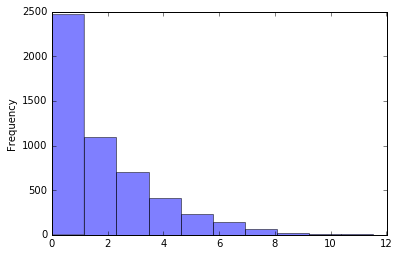

In [12]:
%matplotlib inline
summary_to_reviews.reviews_per_month.plot.hist(alpha=0.5)

From the summary figures, we can see that the 75th percentile is 2.76 reviews_per_month. To use that as a reference, we will categorize listings with 3 or more reviews per month and above as popular, and unpopular if otherwise.

In [6]:
summary_to_reviews["Popularity"] = summary_to_reviews.reviews_per_month >= 3
summary_to_pop = summary_to_reviews[["summary", "Popularity"]]

In [7]:
summary_to_pop.head()

,summary,Popularity
0,This is a big well designed space. Our neighbo...,False
2,Convenience is the key for your travel. Walkin...,False
4,Our family-friendly condo is located in San Fr...,False
5,Large 2BD apt with back yard and ocean view. F...,False
6,Newly built cottage that comfortably sleeps 2....,True


Checking on the value counts, the true/false split seems all right.

In [8]:
summary_to_pop.Popularity.value_counts()

False    3976
True     1181
Name: Popularity, dtype: int64

So lets proceed with the Y and x creation.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
countvect = CountVectorizer(ngram_range=(1,2))

trainsummary = countvect.fit(summary_to_pop["summary"])

The vectorized vocabulary set looks in order.

In [10]:
print trainsummary
print trainsummary.get_feature_names()[:20]

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
[u'00', u'00 blocks', u'00 check', u'00 cleaning', u'00 pm', u'00 this', u'00 to', u'00 visitor', u'00 we', u'000', u'000 00', u'000 btu', u'000 month', u'000 sq', u'000 square', u'000 thread', u'000sqft', u'000sqft in', u'00am', u'00am the']


So we transform the vocabulary and build the X and y variables..

In [15]:
transformx = trainsummary.transform(summary_to_pop["summary"])
#print transformx[:10]

transformx_back = transformx.toarray()
#print transformx_back

X = transformx_back
y = summary_to_pop.Popularity
print X[:5]
print y[:5]

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
0    False
2    False
4    False
5    False
6     True
Name: Popularity, dtype: bool


and we split the set up into train and test sets..

In [16]:
from sklearn.cross_validation import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=70)

We will also include the helper functions from our lab in class.

In [17]:
# a few helper functions
def accuracy_report(_clf):
    print "Accuracy on test data: %0.2f%%" % (100 * _clf.score(xtest, ytest))

    #Print the accuracy on the test and training dataset
    training_accuracy = _clf.score(xtrain, ytrain)
    test_accuracy = _clf.score(xtest, ytest)

    print "Accuracy on training data: %0.2f%%" % (training_accuracy)
    
# a function to run some tests
def AnalyzeReview(testquote, _clf):
    print "The test quote" + " is judged by clasifier to be..."
    testquote = trainsummary.transform([testquote])

    if (_clf.predict(testquote)[0] == 1):
        print "... a popular listing."
    else:
        print "... an unpopular listing."
    return(_clf.predict(testquote)[0])

We will fit the training set to the Multinomial Naive Bayes, Bernoulli Naive Bayes, and logistic regression models.

In [18]:
from sklearn.naive_bayes import MultinomialNB
clfm = MultinomialNB()
clfm.fit(xtrain, ytrain)

from sklearn.naive_bayes import BernoulliNB
clfb = BernoulliNB()
clfb.fit(xtrain, ytrain)

from sklearn.linear_model import LogisticRegression
clfl = LogisticRegression()
clfl.fit(xtrain, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

For each fitting, we will test predict the listing 

*'Newly built cottage that comfortably sleeps 2. This brand new cottage is warm, safe, and perfectly located for the ultimate and most convenient way to visit San Francisco. Beautiful views of the pacific ocean and a few blocks from golden gate park. '*, 

which is a **popular** listing.

In [19]:
summary_for_acc_testing = 'Newly built cottage that comfortably sleeps 2. This brand new cottage is warm, safe, and perfectly located for the ultimate and most convenient way to visit San Francisco. Beautiful views of the pacific ocean and a few blocks from golden gate park. '

Now lets see the results..

In [20]:
print "MultinomialNB Results:"
accuracy_report(clfm)
AnalyzeReview(summary_for_acc_testing, clfm)
print
print "BernoulliNB Results:"
accuracy_report(clfb)
AnalyzeReview(summary_for_acc_testing, clfb)
print
print "Logistic Regession:"
accuracy_report(clfl)
AnalyzeReview(summary_for_acc_testing, clfl)

MultinomialNB Results:
Accuracy: on test data: 74.81%
Accuracy on training data: 0.92%
The test quote is judged by clasifier to be...
... a popular listing.

BernoulliNB Results:
Accuracy: on test data: 77.81%
Accuracy on training data: 0.83%
The test quote is judged by clasifier to be...
... an unpopular listing.

Logistic Regession:
Accuracy: on test data: 77.13%
Accuracy on training data: 0.99%
The test quote is judged by clasifier to be...
... a popular listing.


True

![alt text](minion-yay-2.png "Title")

Better than expected results! By just using the summary description, we are able to predict the outcome of the listing at over 74% accuracy. This is promising.

Going forward, there are other data fields such as location, crime rates, etc, that could improve the accuracy. Potentially, we could also get all the BART station locations and measure the distance to the listing location as a feature.

I also think it would be of interest if the summary descriptions of the popular and unpopular listings could be analysed to see if we could tease out the characterstics that makes a popular listing.